In [ ]:
import sys
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
import optax

sys.path.append("..")
import harmonic_oscillator
import solvers
import utils
import base_optim

reload(harmonic_oscillator)
reload(solvers)
reload(utils)
reload(base_optim)

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([-2, 0], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def plot(cs, u_errors, gs, tls):
    num_iters, num_params = cs.shape
    ils = np.arange(num_iters)

    # Make sure there's one more axes than there are parameters (for plotting
    # the error).
    q = (num_params + 1) // 2
    fig, axs = plt.subplots(
        q if num_params % 2 == 1 else q + 1, 2, figsize=(10, 20)
    )
    # Delete last axes if unused.
    if num_params % 2 == 0:
        plt.delaxes(axs[-1, 0])

    i, j = 0, 0
    for k, c in enumerate(cs.T):
        g = gs[k] if k < len(gs) else 0

        ax = axs[i, j]
        ax.hlines(g, ils[0], ils[-1], label=f"g{k}", color="black")
        ax.plot(ils, c, label=f"c{k}")
        ax.legend()
        ax.set_title(f"c{k} vs {f'g{k}' if k < len(gs) else 0}")
        ax.set_xlabel("Iteration number")

        # Iterate through axs first from left to right, then top to bottom.
        if j == 1:
            i += 1
            j = 0
        else:
            j += 1

    ax = axs[-1, -1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# System evolution parameters
g1, g2, g3, g4 = 1, -1, 0.1, 0.75
c1, c2, c3 = g1, g2, g3
μ = 10

gs = jnp.array([g1, g2, g3, g4])
bs = jnp.array([])
cs = 0.5 * jnp.ones(14)

observed_slice = jnp.s_[:]

prune = False
if prune:
    HarmonicOscillator_Pruned = base_optim.pruned_factory(
        harmonic_oscillator.HarmonicOscillator
    )
    threshold = np.full(14, 0.05)  # In this case could set `threshold = 0.05`.
    iterations = np.full(14, 10)  # Or here `iterations = 10`.

    system = HarmonicOscillator_Pruned(
        μ,
        gs,
        bs,
        cs,
        observed_slice,
        threshold=threshold,
        iterations=iterations,
    )
else:
    system = harmonic_oscillator.HarmonicOscillator(
        μ, gs, bs, cs, observed_slice
    )

solver = solvers.RK4(system)

optimizer = optax.adam(1e-1)
optimizer = base_optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 100
t_relax = 1

return_all = True
cs, u_errors, tls, true, nudged = utils.run_update(
    system,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    *get_initial_values(),
    optimizer=optimizer,
    return_all=return_all,
)
tls_all = np.arange(len(true)) * dt

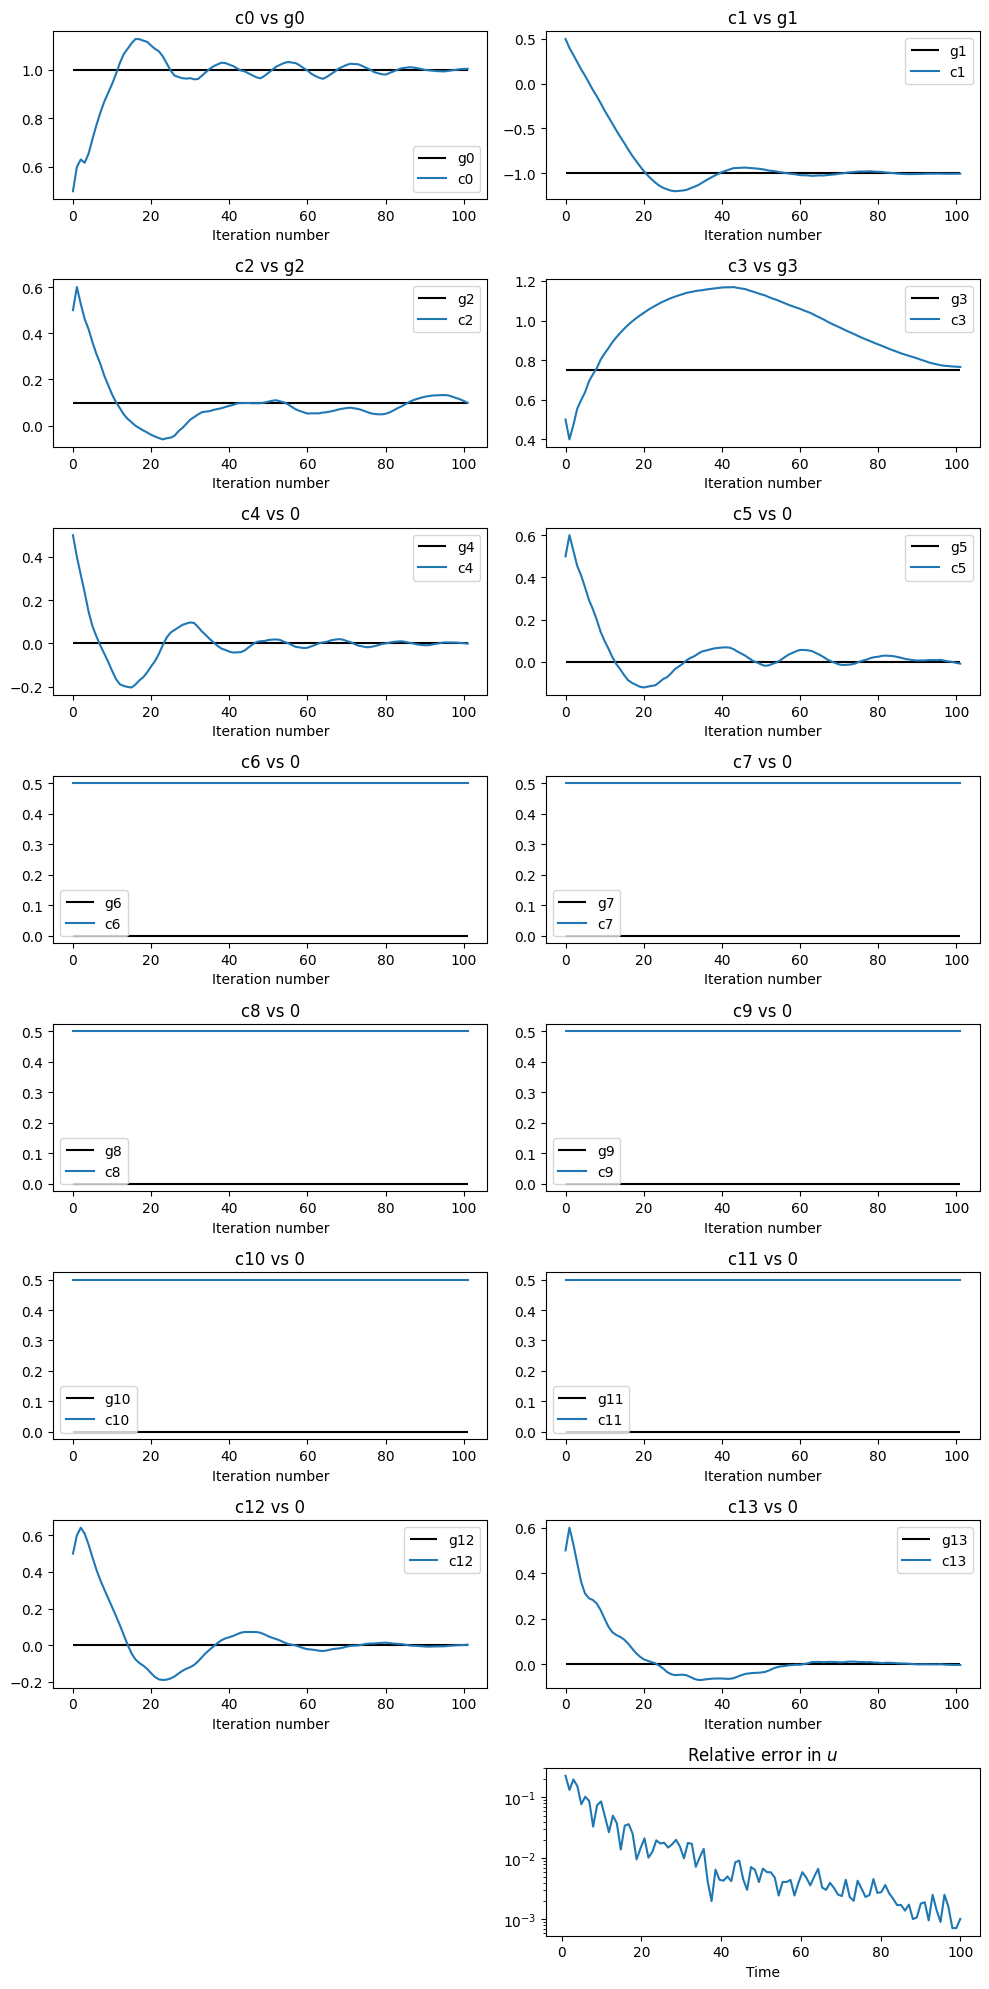

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
plt.show()

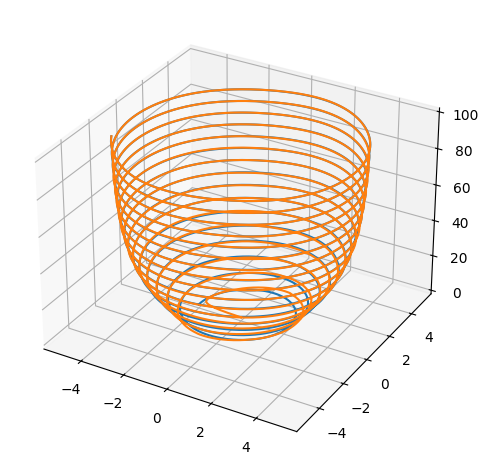

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})

ax.plot(*true.T, tls_all)
ax.plot(*nudged.T, tls_all)

fig.tight_layout()
plt.show()